# LRA based attacks

## Outline

[Content](#content)

[Prerequisite packages and settings](#prerequisite-packages-and-settings)

[Targeted cryptographic function $f$: AES Sbox](#aes)

- [Step 1: Traces generation and preprocessing](#aes-step-1)

- [Step 2: Attack phase](#aes-step-2)

[Targeted cryptographic function $f$: XOR operation](#xor)

- [Step 1: Traces generation and preprocessing](#xor-step-1)

- [Step 2: Attack phase](#xor-step-2)

[Targeted cryptographic function $f$: Prince Sbox](#prince)

- [Step 1: Traces generation and preprocessing](#prince-step-1)

- [Step 2: Attack phase](#prince-step-2)

[Targeted cryptographic function $f$: Clyde128 Sbox](#clyde)

- [Step 1: Traces generation and preprocessing](#clyde-step-1)

- [Step 2: Attack phase](#clyde-step-2)


## Content <a class='anchor' id='content'></a>

In this notebook, we propose to conduct non profiled attacks using Linear Regression Analysis with our proposed distinguishers considering different targeted cryptographic functions $f$.

To do so, we propose in this notebook to attack simulated traces. 
For each targeted cryptographic function $f$, we first generate a set of attack traces. 
Then LRA based attacks are done considering state-of-the-art distinguishers and our proposed distinguishers (see Section 4).

This notebook is provided as an example. In particular, users are free to adapt this notebook to suit the dataset they want to target.

## Prerequisite packages and settings <a class='anchor' id='prerequisite-packages-and-settings'></a>

Here are the Python packages and settings needed to run properly this notebook.

In [1]:
from LRA.LRA_implementations import *
from LRA.LRA_utils import *
from matplotlib import pyplot as plt

plt.rcParams['text.usetex'] = True

## Targeted cryptographic function $f$: AES Sbox <a class='anchor' id='aes'></a>

In this section, the cryptographic function considered is AES Sbox.
The first step consists thus in generating traces manipulating as targeted variables AES Sbox output.
Then, we carry out LRA based attacks considering state-of-the-art distinguishers and our proposed distinguishers.
Finally we compare attack performances obtained using as attack metric the guessing entropy *i.e.* expected rank of the true key $k^*$.

### Step 1: Traces generation and preprocessing <a class='anchor' id='aes-step-1'></a>

The generation of traces is done using a function called $\texttt{generate\_traces}$, available in $\texttt{LRA\_utils.py}$ file. 

In the following example, we generate $100,000$ attack traces of $1,000$ samples such that $1\%$ are PoIs. 
We consider the fourth scenario with a non-isotropic Gaussian noise of parameters $\mu=0$ and $\sigma=\{1,5,10\}$.
The targeted byte is $0$ and the key is $k^*=\texttt{0x4a}$. 

We set the seed to $42$ to have reproductible results. 

In [2]:
# Traces generation
targeted_byte = 0
aes_true_key = [0x4a]

aes_attack_traces, aes_attack_plaintexts, aes_attack_targeted_variables, aes_sigmas = generate_traces(nb_traces=100000, nb_samples=1000, nb_poi=10, mu=0, isotropic_noise=False,\
                                                                                                      sigmas=np.array([1,5,10]), scenario="scenario_4", targeted_variables_type='aes_sbox', \
                                                                                                      targeted_variables_size=8, targeted_byte=targeted_byte, key=aes_true_key, seed=42)
                                                                        
print("Attack traces generated \U00002705")

Attack traces generated ✅


Here is an example of generated traces.

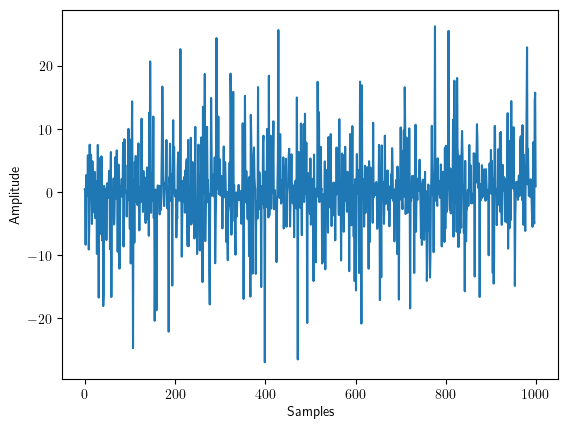

In [3]:
# Plot of a trace
plt.plot(aes_attack_traces[0,:])
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

Then, we apply on these traces preprocessing techniques. Specifically, we apply Maximum absolute value scaling (see Section 5.1.1 in our paper, paragraph *Configuration*).

In [4]:
from sklearn.preprocessing import MaxAbsScaler

aes_max_scaler = MaxAbsScaler()

aes_attack_traces = aes_max_scaler.fit_transform(aes_attack_traces)

The amplitude of traces is rescaled.

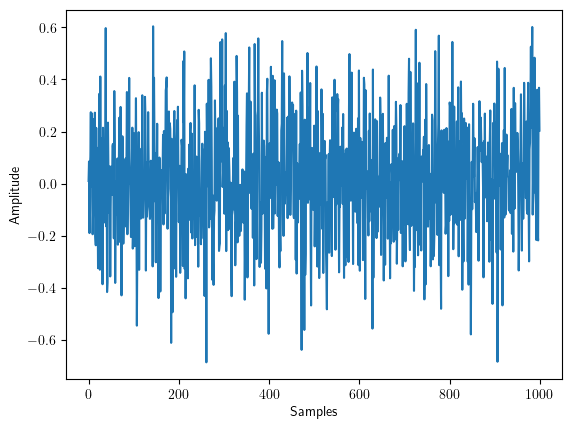

In [5]:
# Plot of a rescaled trace
plt.plot(aes_attack_traces[0,:])
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

### Step 2: Attack phase <a class='anchor' id='aes-step-2'></a>

Once attack traces are generated, we carry out LRA attacks using $\texttt{LRA\_averaged\_attacks}$ function (see $\texttt{LRA\_implementations.py}$ file) considering $\texttt{nb\_traces}=[1000, 2000, 3000, 5000, 10000]$ traces.
For all attacks, we consider coalesced LRA.
For each traces number, we compute mean rank evolutions by averaging over $\texttt{total\_nb\_attack}=10$ attacks. 

All attacks are conducted with a full basis *i.e.* all bits interactions are taken into account and considering $R^2$ distinguisher, normalized $R^2$ distinguisher and maximum distinguisher (see Section 4.1.3, Proposition 4 in our paper).

<u>Reminder:</u> the basis used to perform LRA attacks considering all bits interactions is the Walsh-Hadamard basis (see Section 2.1, paragraph *Bases considered in SCA* of our paper).

In [6]:
# Running LRA attacks on simulated traces
from LRA.LRA_utils import aes_sbox_vectorized
nb_traces = [1000, 2000, 3000, 5000, 10000]

aes_mean_rank_max_dist, aes_mean_rank_r2, aes_mean_rank_norm_r2 = LRA_averaged_attacks(total_nb_attack=10, LRA_attack='LRA_coalesced', true_key=aes_true_key[targeted_byte], \
                                                                                       nb_traces=nb_traces, attack_traces=aes_attack_traces, attack_plaintexts=aes_attack_plaintexts,\
                                                                                       len_basis=256, deg_monomials_interactions=8, nb_possible_plaintexts_values=256, nb_hypothesis=256,\
                                                                                       targeted_f_type='sbox', sbox=aes_sbox_vectorized, distinguisher='maximum_distinguisher')

print("Attacks done \U00002705")

  0%|          | 0/5 [00:00<?, ?it/s]c:\Users\bouss\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\bouss\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\_core\_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
 20%|██        | 1/5 [01:28<05:55, 88.99s/it]c:\Users\bouss\OneDrive\Bureau\Papier LRA code\LRA\LRA_implementations.py:45: RuntimeWarning: invalid value encountered in divide
  normalized_max = (max_u - mu_R2_scores)/sigma_R2_scores
100%|██████████| 5/5 [06:19<00:00, 75.97s/it]

Attacks done ✅


Now, we plot for each distinguisher its mean rank evolution.

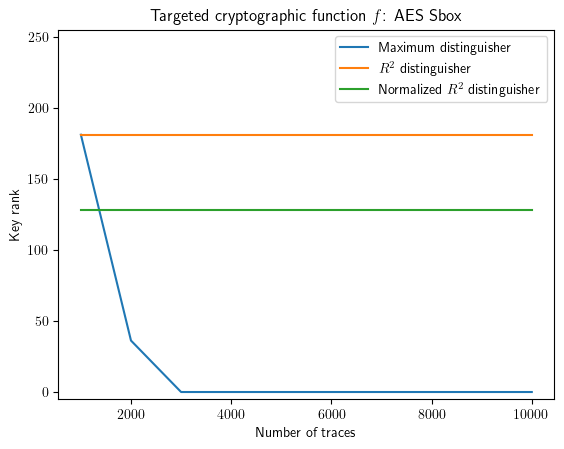

In [7]:
# Plot of mean rank evolutions for all considered distinguishers
plt.plot(nb_traces, aes_mean_rank_max_dist)
plt.plot(nb_traces, aes_mean_rank_r2)
plt.plot(nb_traces, aes_mean_rank_norm_r2)
plt.legend([r'Maximum distinguisher', r'$R^2$ distinguisher', r'Normalized $R^2$ distinguisher'])
plt.title(r'Targeted cryptographic function $f$: AES Sbox')
plt.xlabel("Number of traces")
plt.ylabel("Key rank")
plt.ylim([-5, 255])
plt.show()

As we can see, the correct key is recovered only when considering our proposed distinguisher. 
The number of traces required to retrieve the key is $3,000$.

## Targeted cryptographic function $f$: XOR operation <a class='anchor' id='xor'></a>

In this section, the cryptographic function considered is a XOR operation.
The first step consists thus in generating traces manipulating as targeted variables a XOR operation.
Then, we carry out LRA based attacks considering state-of-the-art distinguishers and our proposed distinguishers.
Finally we compare attack performances obtained using as attack metric the guessing entropy *i.e.* expected rank of the true key $k^*$.

### Step 1: Traces generation and preprocessing <a class='anchor' id='xor-step-1'></a>

The generation of traces is done using a function called $\texttt{generate\_traces}$, available in $\texttt{LRA\_utils.py}$ file. 

In the following example, we generate $100,000$ attack traces of $1,000$ samples such that $1\%$ are PoIs. 
We consider the fourth scenario with a non-isotropic Gaussian noise of parameters $\mu=0$ and $\sigma=\{1,5,10\}$.
The targeted byte is $0$ and the key is $k^*=\texttt{0x4a}$. 

We set the seed to $42$ to have reproductible results. 

In [8]:
# Traces generation
targeted_byte = 0
xor_true_key = [0x4a]

xor_attack_traces, xor_attack_plaintexts, xor_attack_targeted_variables, xor_sigmas = generate_traces(nb_traces=100000, nb_samples=1000, nb_poi=10, mu=0, isotropic_noise=False, \
                                                                                                      sigmas=np.array([1,5,10]), scenario="scenario_4", targeted_variables_type='xor', \
                                                                                                      targeted_variables_size=8, targeted_byte=targeted_byte, key=xor_true_key, seed=42)
                                                                        
print("Attack traces generated \U00002705")

# Preprocessing
from sklearn.preprocessing import MaxAbsScaler

xor_max_scaler = MaxAbsScaler()

xor_attack_traces = xor_max_scaler.fit_transform(xor_attack_traces)


Attack traces generated ✅


Here is an example of generated traces.

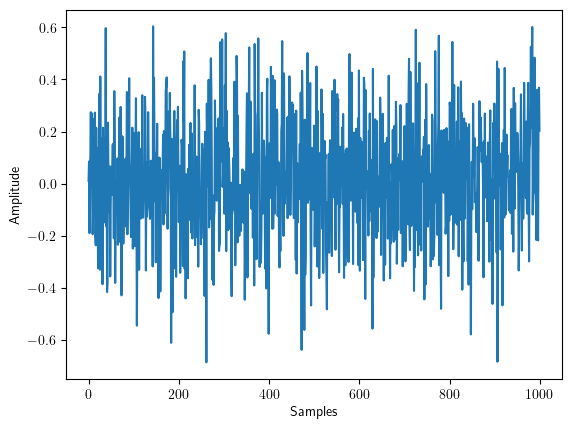

In [9]:
# Plot of a trace
plt.plot(xor_attack_traces[0,:])
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

Then, we apply on these traces preprocessing techniques. Specifically, we apply Maximum absolute value scaling (see Section 5.1.1 in our paper, paragraph *Configuration*).

In [10]:
from sklearn.preprocessing import MaxAbsScaler

xor_max_scaler = MaxAbsScaler()

xor_attack_traces = xor_max_scaler.fit_transform(xor_attack_traces)

The amplitude of traces is rescaled.

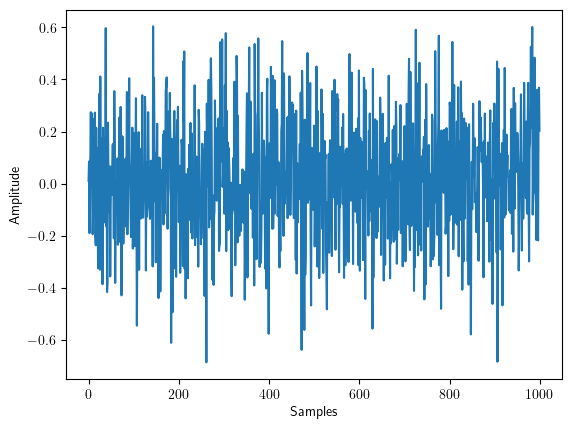

In [11]:
# Plot of a rescaled trace
plt.plot(xor_attack_traces[0,:])
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

### Step 2: Attack phase <a class='anchor' id='xor-step-2'></a>

Once attack traces are generated, we carry out LRA attacks using $\texttt{LRA\_averaged\_attacks}$ function (see $\texttt{LRA\_implementations.py}$ file) considering $\texttt{nb\_traces}=[1000, 2000, 3000, 5000, 10000]$ traces.
For all attacks, we consider coalesced LRA.
For each traces number, we compute mean rank evolutions by averaging over $\texttt{total\_nb\_attack}=10$ attacks. 

All attacks are conducted with a full basis *i.e.* all bits interactions are taken into account and considering $R^2$ distinguisher, normalized $R^2$ distinguisher and maximum distinguisher (see Section 4.1.3, Proposition 4 in our paper).

<u>Reminder:</u> the basis used to perform LRA attacks considering all bits interactions is the Walsh-Hadamard basis (see Section 2.1, paragraph *Bases considered in SCA* of our paper).

In [12]:
# Running LRA attacks on simulated traces
nb_traces = [1000, 2000, 3000, 5000, 10000]

xor_mean_rank_abs_sum_dist, xor_mean_rank_r2, xor_mean_rank_norm_r2 = LRA_averaged_attacks(total_nb_attack=10, LRA_attack='LRA_coalesced', true_key=xor_true_key[targeted_byte], \
                                                                                           nb_traces=nb_traces, attack_traces=xor_attack_traces, attack_plaintexts=xor_attack_plaintexts, \
                                                                                           len_basis=256, deg_monomials_interactions=8, nb_possible_plaintexts_values=256, nb_hypothesis=256, \
                                                                                           targeted_f_type='xor', sbox=None, distinguisher='absolute_value_sum_distinguisher')

print("Attacks done \U00002705")

  0%|          | 0/5 [00:00<?, ?it/s]c:\Users\bouss\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\bouss\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\_core\_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
 20%|██        | 1/5 [01:13<04:54, 73.53s/it]c:\Users\bouss\OneDrive\Bureau\Papier LRA code\LRA\LRA_implementations.py:45: RuntimeWarning: invalid value encountered in divide
  normalized_max = (max_u - mu_R2_scores)/sigma_R2_scores
100%|██████████| 5/5 [06:01<00:00, 72.26s/it]

Attacks done ✅


Now, we plot for each distinguisher its mean rank evolution.

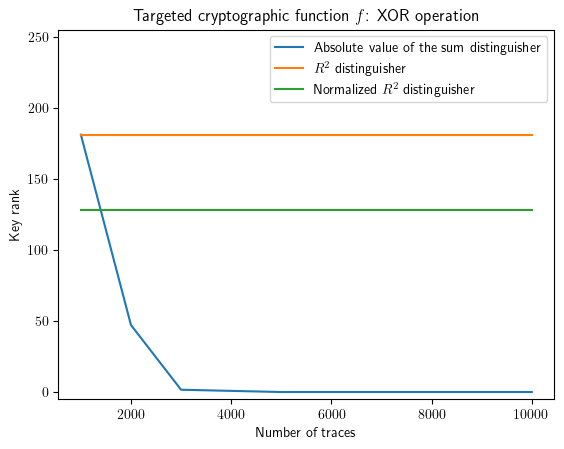

In [13]:
# Plot of mean rank evolutions for all considered distinguishers
plt.plot(nb_traces, xor_mean_rank_abs_sum_dist)
plt.plot(nb_traces, xor_mean_rank_r2)
plt.plot(nb_traces, xor_mean_rank_norm_r2)
plt.legend([r'Absolute value of the sum distinguisher', r'$R^2$ distinguisher', r'Normalized $R^2$ distinguisher'])
plt.xlabel("Number of traces")
plt.ylabel("Key rank")
plt.title(r'Targeted cryptographic function $f$: XOR operation')
plt.ylim([-5, 255])
plt.show()

As we can see, the correct key is recovered only when considering our proposed distinguisher, within $XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX$ traces.

## Targeted cryptographic function $f$: Prince Sbox <a class='anchor' id='prince'></a>

In this section, the cryptographic function considered is Prince Sbox.
The first step consists thus in generating traces manipulating as targeted variables Prince Sbox output.
Then, we carry out LRA based attacks considering state-of-the-art distinguishers and our proposed distinguishers.
Finally we compare attack performances obtained using as attack metric the guessing entropy *i.e.* expected rank of the true key $k^*$.

### Step 1: Traces generation <a class='anchor' id='prince-step-1'></a>

The generation of traces is done using a function called $\texttt{generate\_traces}$, available in $\texttt{LRA\_utils.py}$ file. 

In the following example, we generate $100,000$ attack traces of $1,000$ samples such that $1\%$ are PoIs. 
We consider the fourth scenario with a non-isotropic Gaussian noise of parameters $\mu=0$ and $\sigma=\{1,5,10\}$.
We consider the first four bits of the true key: $k^*=\texttt{0xa}$. 

We set the seed to $42$ to have reproductible results. 

In [2]:
# Traces generation
index_targeted_four_bits = 0
prince_true_key = [0xa]

prince_attack_traces, prince_attack_plaintexts, prince_attack_targeted_variables, prince_sigmas = generate_traces(nb_traces=100000, nb_samples=1000, nb_poi=10, mu=0, isotropic_noise=False, \
                                                                                                                  sigmas=np.array([1,5,10]), alpha=np.array([1, 0.5, 1, 0]), \
                                                                                                                  beta=np.array([1, 2, 0.5, 0.25, 1, 0.15, 1, 0.4, 0.3, 0.6, 0.2, 0.1]), \
                                                                                                                  scenario="scenario_4", targeted_variables_type='prince_sbox', \
                                                                                                                  targeted_variables_size=4, targeted_byte=index_targeted_four_bits, \
                                                                                                                  key=prince_true_key, seed=42)
                                                                        
print("Attack traces generated \U00002705")

Attack traces generated ✅


Here is an example of generated traces.

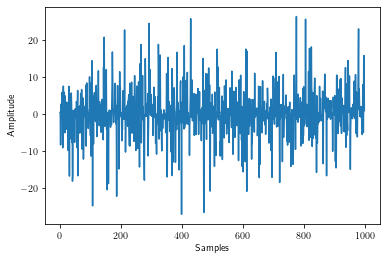

In [3]:
# Plot of a trace
plt.plot(prince_attack_traces[0,:])
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

Then, we apply on these traces preprocessing techniques. Specifically, we apply Maximum absolute value scaling (see Section 5.1.1 in our paper, paragraph *Configuration*).

In [4]:
from sklearn.preprocessing import MaxAbsScaler

prince_max_scaler = MaxAbsScaler()

prince_attack_traces = prince_max_scaler.fit_transform(prince_attack_traces)

The amplitude of traces is rescaled.

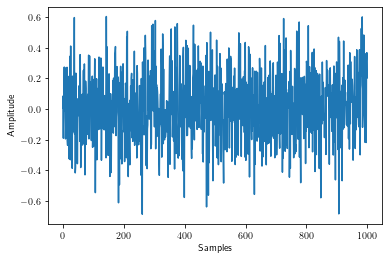

In [5]:
# Plot of a rescaled trace
plt.plot(prince_attack_traces[0,:])
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

### Step 2: Attack phase <a class='anchor' id='prince-step-2'></a>

Once attack traces are generated, we carry out LRA attacks using $\texttt{LRA\_averaged\_attacks}$ function (see $\texttt{LRA\_implementations.py}$ file) considering $\texttt{nb\_traces}=[100, 200, 300, 500, 750, 1000]$ traces.
For all attacks, we consider coalesced LRA.
For each traces number, we compute mean rank evolutions by averaging over $\texttt{total\_nb\_attack}=10$ attacks. 

All attacks are conducted with a full basis *i.e.* all bits interactions are taken into account and considering $R^2$ distinguisher, normalized $R^2$ distinguisher and maximum distinguisher (see Section 4.1.3, Proposition 4 in our paper).

<u>Reminder:</u> the basis used to perform LRA attacks considering all bits interactions is the Walsh-Hadamard basis (see Section 2.1, paragraph *Bases considered in SCA* of our paper).

In [6]:
# Running LRA attacks on simulated traces
from LRA.LRA_utils import prince_sbox_vectorized
nb_traces = [100, 200, 300, 500, 1000, 2000]

prince_mean_rank_max_dist, prince_mean_rank_r2, prince_mean_rank_norm_r2 = LRA_averaged_attacks(total_nb_attack=10, LRA_attack='LRA_coalesced', \
                                                                                                true_key=prince_true_key[index_targeted_four_bits], nb_traces=nb_traces, \
                                                                                                attack_traces=prince_attack_traces, attack_plaintexts=prince_attack_plaintexts, len_basis=16,\
                                                                                                deg_monomials_interactions=4, nb_possible_plaintexts_values=16, nb_hypothesis=16, \
                                                                                                targeted_f_type='sbox', sbox=prince_sbox_vectorized, distinguisher='maximum_distinguisher')

print("Attacks done \U00002705")

  0%|          | 0/6 [00:00<?, ?it/s]/data/ssd/SBO/These/Papier LRA code en cours/LRA/LRA_implementations.py:45: RuntimeWarning: invalid value encountered in true_divide
  normalized_max = (max_u - mu_R2_scores)/sigma_R2_scores
100%|██████████| 6/6 [00:00<00:00, 12.71it/s]

Attacks done ✅


Now, we plot for each distinguisher its mean rank evolution.

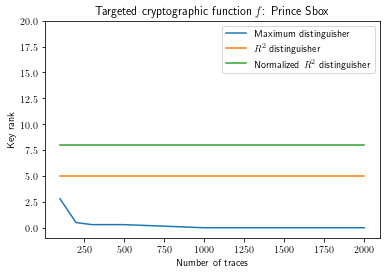

In [7]:
# Plot of mean rank evolutions for all considered distinguishers
plt.plot(nb_traces, prince_mean_rank_max_dist)
plt.plot(nb_traces, prince_mean_rank_r2)
plt.plot(nb_traces, prince_mean_rank_norm_r2)
plt.legend([r'Maximum distinguisher', r'$R^2$ distinguisher', r'Normalized $R^2$ distinguisher'])
plt.xlabel("Number of traces")
plt.ylabel("Key rank")
plt.title(r'Targeted cryptographic function $f$: Prince Sbox')
plt.ylim([-1, 20])
plt.show()

  0%|          | 0/6 [00:00<?, ?it/s]/data/ssd/SBO/These/Papier LRA code en cours/LRA/LRA_implementations.py:45: RuntimeWarning: invalid value encountered in true_divide
  normalized_max = (max_u - mu_R2_scores)/sigma_R2_scores
100%|██████████| 6/6 [00:05<00:00,  1.13it/s]

Attacks done ✅


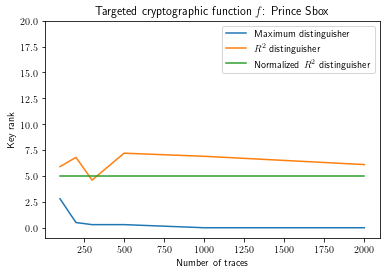

[2.8 0.5 0.3 0.3 0.  0. ]
[5.9 6.8 4.6 7.2 6.9 6.1]
[5. 5. 5. 5. 5. 5.]


In [6]:
# Running LRA attacks on simulated traces
from LRA.LRA_utils import prince_sbox_vectorized
nb_traces = [100, 200, 300, 500, 1000, 2000]

prince_mean_rank_max_dist, prince_mean_rank_r2, prince_mean_rank_norm_r2 = LRA_averaged_attacks(total_nb_attack=10, LRA_attack='LRA', \
                                                                                                true_key=prince_true_key[index_targeted_four_bits], nb_traces=nb_traces, \
                                                                                                attack_traces=prince_attack_traces, attack_plaintexts=prince_attack_plaintexts, len_basis=16,\
                                                                                                deg_monomials_interactions=4, nb_possible_plaintexts_values=16, nb_hypothesis=16, \
                                                                                                targeted_f_type='sbox', sbox=prince_sbox_vectorized, distinguisher='maximum_distinguisher')

print("Attacks done \U00002705")


# Plot of mean rank evolutions for all considered distinguishers
plt.plot(nb_traces, prince_mean_rank_max_dist)
plt.plot(nb_traces, prince_mean_rank_r2)
plt.plot(nb_traces, prince_mean_rank_norm_r2)
plt.legend([r'Maximum distinguisher', r'$R^2$ distinguisher', r'Normalized $R^2$ distinguisher'])
plt.xlabel("Number of traces")
plt.ylabel("Key rank")
plt.title(r'Targeted cryptographic function $f$: Prince Sbox')
plt.ylim([-1, 20])
plt.show()

print(prince_mean_rank_max_dist)
print(prince_mean_rank_r2)
print(prince_mean_rank_norm_r2)

In [8]:
scores = np.random.randint(0,25,(256,100))
mu_R2_scores = np.mean(scores, axis=0)
sigma_R2_scores = np.mean((scores - mu_R2_scores)**2, axis=0)
max_u = np.max(scores, axis=0)
argmax_u = np.argsort(scores, axis=0)
normalized_max = (max_u - mu_R2_scores)/sigma_R2_scores
keys_ranking = argmax_u[np.argmax(normalized_max)]

In [12]:
keys_ranking

array([ 89,  42,  46, 174, 245,  27, 240,  92, 101, 114,  72, 136,  56,
        59,  35,   1,  15, 253, 229, 126, 177, 229,  54,   5,  55,  21,
       146,  38, 170,  66, 195, 151,  47,  12, 182, 165, 116, 101,   0,
       165, 251, 153, 204, 149, 165,  37, 160,  80, 191, 216,   8,  49,
        54, 120, 123, 130,  34,  34, 116,  47, 200, 210, 130,  66,  59,
       243, 244,  84, 209, 146, 191, 143,   8,  60,  88, 187, 109, 220,
        83, 203, 199,  44, 192,  89,  89,  75, 178,   4,  32,  59, 148,
        55, 249, 165,  82, 122, 206,  48, 141, 187])

As we can see, the correct key is recovered only when considering our proposed distinguisher.
The correct key is retrieved within $1,000$ traces.

## Targeted cryptographic function $f$: Clyde128 Sbox <a class='anchor' id='clyde'></a>

In this section, the cryptographic function considered is Clyde128 Sbox.
The first step consists thus in generating traces manipulating as targeted variables Clyde128 Sbox output.
Then, we carry out LRA based attacks considering state-of-the-art distinguishers and our proposed distinguishers.
Finally we compare attack performances obtained using as attack metric the guessing entropy *i.e.* expected rank of the true key $k^*$.

### Step 1: Traces generation <a class='anchor' id='clyde-step-1'></a>

The generation of traces is done using a function called $\texttt{generate\_traces}$, available in $\texttt{LRA\_utils.py}$ file. 

In the following example, we generate $100,000$ attack traces of $1,000$ samples such that $1\%$ are PoIs. 
We consider the fourth scenario with a non-isotropic Gaussian noise of parameters $\mu=0$ and $\sigma=\{1,5,10\}$.
We consider the first four bits of the true key: $k^*=\texttt{0xa}$. 

We set the seed to $42$ to have reproductible results. 

In [12]:
# Traces generation
index_targeted_four_bits = 0
clyde_true_key = [0xa]

clyde_attack_traces, clyde_attack_plaintexts, clyde_attack_targeted_variables, clyde_sigmas = generate_traces(nb_traces=100000, nb_samples=1000, nb_poi=10, mu=0, isotropic_noise=False, \
                                                                                                              sigmas=np.array([1,5,10]), alpha=np.array([1, 0.5, 1, 0]), \
                                                                                                              beta=np.array([1, 2, 0.5, 0.25, 1, 0.15, 1, 0.4, 0.3, 0.6, 0.2, 0.1]), \
                                                                                                              scenario="scenario_4", targeted_variables_type='clyde_sbox', \
                                                                                                              targeted_variables_size=4, targeted_byte=index_targeted_four_bits, \
                                                                                                              key=clyde_true_key, seed=42)
                                                                        
print("Attack traces generated \U00002705")

Attack traces generated ✅


Here is an example of generated traces.

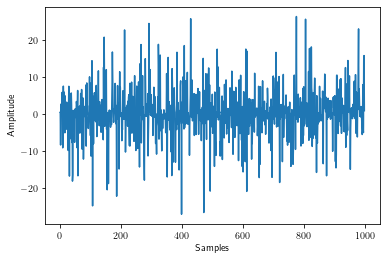

In [13]:
# Plot of a trace
plt.plot(clyde_attack_traces[0,:])
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

Then, we apply on these traces preprocessing techniques. Specifically, we apply Maximum absolute value scaling (see Section 5.1.1 in our paper, paragraph *Configuration*).

In [14]:
from sklearn.preprocessing import MaxAbsScaler

clyde_max_scaler = MaxAbsScaler()

clyde_attack_traces = clyde_max_scaler.fit_transform(clyde_attack_traces)

The amplitude of traces is rescaled.

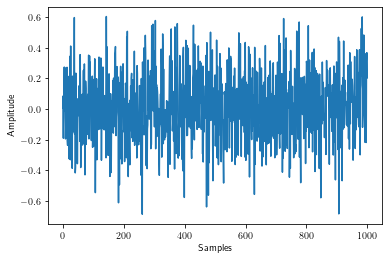

In [15]:
# Plot of a rescaled trace
plt.plot(clyde_attack_traces[0,:])
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

### Step 2: Attack phase <a class='anchor' id='clyde-step-2'></a>

Once attack traces are generated, we carry out LRA attacks using $\texttt{LRA\_averaged\_attacks}$ function (see $\texttt{LRA\_implementations.py}$ file) considering $\texttt{nb\_traces}=[100, 200, 300, 500, 750, 1000]$ traces.
For all attacks, we consider coalesced LRA.
For each traces number, we compute mean rank evolutions by averaging over $\texttt{total\_nb\_attack}=10$ attacks. 

All attacks are conducted with a full basis *i.e.* all bits interactions are taken into account and considering $R^2$ distinguisher, normalized $R^2$ distinguisher and maximum distinguisher (see Section 4.1.3, Proposition 4 in our paper).

<u>Reminder:</u> the basis used to perform LRA attacks considering all bits interactions is the Walsh-Hadamard basis (see Section 2.1, paragraph *Bases considered in SCA* of our paper).

In [16]:
# Running LRA attacks on simulated traces
from LRA.LRA_utils import clyde_sbox_vectorized
nb_traces = [100, 200, 300, 500, 750, 1000]

clyde_mean_rank_abs_sum_dist, clyde_mean_rank_r2, clyde_mean_rank_norm_r2 = LRA_averaged_attacks(total_nb_attack=10, LRA_attack='LRA_coalesced',\
                                                                                                 true_key=clyde_true_key[index_targeted_four_bits], nb_traces=nb_traces, \
                                                                                                 attack_traces=clyde_attack_traces, attack_plaintexts=clyde_attack_plaintexts, len_basis=16, \
                                                                                                 deg_monomials_interactions=4, nb_possible_plaintexts_values=16, nb_hypothesis=16, \
                                                                                                 targeted_f_type='sbox', sbox=clyde_sbox_vectorized, \
                                                                                                 distinguisher='absolute_value_sum_distinguisher')

print("Attacks done \U00002705")

  0%|          | 0/6 [00:00<?, ?it/s]/data/ssd/SBO/These/Papier LRA code en cours/LRA/LRA_implementations.py:45: RuntimeWarning: invalid value encountered in true_divide
  normalized_max = (max_u - mu_R2_scores)/sigma_R2_scores
100%|██████████| 6/6 [00:00<00:00, 10.49it/s]

Attacks done ✅


Now, we plot for each distinguisher its mean rank evolution.

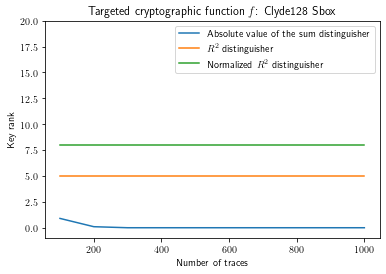

In [17]:
# Plot of mean rank evolutions for all considered distinguishers
plt.plot(nb_traces, clyde_mean_rank_abs_sum_dist)
plt.plot(nb_traces, clyde_mean_rank_r2)
plt.plot(nb_traces, clyde_mean_rank_norm_r2)
plt.legend([r'Absolute value of the sum distinguisher', r'$R^2$ distinguisher', r'Normalized $R^2$ distinguisher'])
plt.xlabel("Number of traces")
plt.ylabel("Key rank")
plt.title(r'Targeted cryptographic function $f$: Clyde128 Sbox')
plt.ylim([-1, 20])
plt.show()

As we can see, the correct key is recovered only when considering our proposed distinguisher, within $300$ traces.

  0%|          | 0/6 [00:00<?, ?it/s]/data/ssd/SBO/These/Papier LRA code en cours/LRA/LRA_implementations.py:45: RuntimeWarning: invalid value encountered in true_divide
  normalized_max = (max_u - mu_R2_scores)/sigma_R2_scores
100%|██████████| 6/6 [00:02<00:00,  2.22it/s]

Attacks done ✅


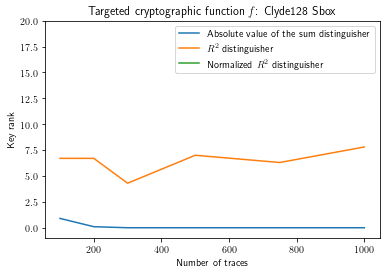

[0.9 0.1 0.  0.  0.  0. ]
[6.7 6.7 4.3 7.  6.3 7.8]
[ 27.4  54.6  78.9 121.8 223.8 217.3]


In [25]:
# Running LRA attacks on simulated traces
from LRA.LRA_utils import clyde_sbox_vectorized
nb_traces = [100, 200, 300, 500, 750, 1000]

clyde_mean_rank_abs_sum_dist, clyde_mean_rank_r2, clyde_mean_rank_norm_r2 = LRA_averaged_attacks(total_nb_attack=10, LRA_attack='LRA',\
                                                                                                 true_key=clyde_true_key[index_targeted_four_bits], nb_traces=nb_traces, \
                                                                                                 attack_traces=clyde_attack_traces, attack_plaintexts=clyde_attack_plaintexts, len_basis=16, \
                                                                                                 deg_monomials_interactions=4, nb_possible_plaintexts_values=16, nb_hypothesis=16, \
                                                                                                 targeted_f_type='sbox', sbox=clyde_sbox_vectorized, \
                                                                                                 distinguisher='absolute_value_sum_distinguisher')

print("Attacks done \U00002705")

# Plot of mean rank evolutions for all considered distinguishers
plt.plot(nb_traces, clyde_mean_rank_abs_sum_dist)
plt.plot(nb_traces, clyde_mean_rank_r2)
plt.plot(nb_traces, clyde_mean_rank_norm_r2)
plt.legend([r'Absolute value of the sum distinguisher', r'$R^2$ distinguisher', r'Normalized $R^2$ distinguisher'])
plt.xlabel("Number of traces")
plt.ylabel("Key rank")
plt.title(r'Targeted cryptographic function $f$: Clyde128 Sbox')
plt.ylim([-1, 20])
plt.show()

print(clyde_mean_rank_abs_sum_dist)
print(clyde_mean_rank_r2)
print(clyde_mean_rank_norm_r2)